In [ ]:
import numpy as np
import cv2
import os
import string
import matplotlib.pyplot as plt
import tqdm
from os.path import join
from collections import Counter
import re 
import io
import copy
from tensorflow.keras import layers
import editdistance

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, LSTM,GRU, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

Бейзлайн запускался на машине со следующими версиями библиотек.

In [ ]:
import keras
import tensorflow as tf

In [ ]:
!wget -c https://storage.yandexcloud.net/datasouls-ods/materials/46b7bb85/datasets.zip

--2023-01-14 12:59:31--  https://storage.yandexcloud.net/datasouls-ods/materials/46b7bb85/datasets.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640106308 (610M) [application/zip]
Saving to: ‘datasets.zip’

datasets.zip        100%[===================>] 610.45M  9.03MB/s    in 64s     

2023-01-14 13:00:37 (9.56 MB/s) - ‘datasets.zip’ saved [640106308/640106308]



In [ ]:
!mkdir aij_data

import zipfile

with zipfile.ZipFile("datasets.zip", "r") as f:
    f.extractall("aij_data")

In [ ]:
trans_dir = 'aij_data/train/words'
image_dir = 'aij_data/train/images'

print(len(os.listdir(trans_dir)))

6196


In [ ]:
import os
from collections import Counter

english = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'm', 'n' ,'o', 'p', 'r', 's', 't', 'u', 'w']

def process_texts(image_dir, trans_dir):
    lens = []
    include_english = 0
    letters = ''

    lines = []
    names = []
    
    all_files = os.listdir(trans_dir)
    for filename in os.listdir(image_dir):
        if filename[:-3]+'txt' in all_files:
            name, ext = os.path.splitext(filename)
            txt_filepath = os.path.join(trans_dir, name + '.txt')
            with open(txt_filepath, 'r') as file:
                data = file.read()
                if len(data)==0:
                    continue
                if len(set(data).intersection(english))>0:
                    continue

                lines.append(data)
                names.append(filename)
                lens.append(len(data))
                letters += data

    print('Максимальная длина строки:', max(lens))
    print('Количество строк с английскими буквами ', include_english)

    return names, lines, Counter(letters)

In [ ]:
example = os.listdir(image_dir)[0]

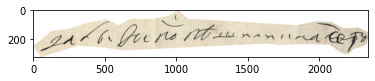

In [ ]:
img = plt.imread(image_dir+'/'+example)
plt.imshow(img)
plt.show()

In [ ]:
with io.open(trans_dir+'/'+example[:-3]+'txt', 'r',  encoding='utf8') as file:
    data = file.read()

print(data)

дабы вы поспѣшили к нам сего


In [ ]:
#def text_to_labels(text):
#    return list(map(lambda x: letters.index(x), text))

In [ ]:
names,lines,cnt = process_texts(image_dir,trans_dir)

Максимальная длина строки: 71
Количество строк с английскими буквами  0


In [ ]:
#letters = set(cnt.keys())

#letters = sorted(list(letters))
letters = sorted(list(cnt.keys()))
print('Символы train:', ' '.join(letters))

Символы train:   ) + / 0 1 2 3 4 5 6 7 8 9 [ ] i k l | × ǂ а б в г д е ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я і ѣ – … ⊕ ⊗


In [ ]:
import numpy as np
import pandas as pd
import random


df = pd.DataFrame(lines, columns=["trg"])

def add_noise(text, symbols=letters, znam=4):
    text = list(text)
    num = len(text) // znam
    indexes = random.sample(range(0, len(text)), num)
    for i in indexes:
        if text[i]!=' ':
            text[i] = random.choice(symbols)
        else:
            del_space = np.random.choice([True, False], p=[0.3, 0.7])
            if del_space:
                text[i] = text[i].replace(" ", "")
    return ''.join(text)


df["src"] = [add_noise(t, znam=4) for t in df["trg"].tolist()]

In [ ]:
df.head()

,trg,src
0,дабы вы поспѣшили к нам сего,мабо выпосп3ши]и к 7а[ сего
1,+,+
2,писмо ваше чрез михеля получил на которое отвѣт,пифзо саше чkѣз ми⊗еля получил 5н коморое отвѣ
3,вою грамоту i просит на оною,вою грдмотн i |рос8т нч оноi
4,до пятницы которого дня ра,до пк+ниця8от9рого дня ра


In [ ]:
!python -m pip install --quiet keras-transformer

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, train_size=0.9, shuffle=True)

In [ ]:
def build_token_dict(text_list):
    token_dict = {
        '<PAD>': 0,
        '<START>': 1,
        '<END>': 2,
    }
    for text in tqdm.tqdm(text_list, total=len(text_list)):
        for token in text:
            if token not in token_dict:
                token_dict[token] = len(token_dict)
    return token_dict

def tokenize(text):
    return list(text)

def prepare_data(df, source_token_dict, target_token_dict):
    df["src_tok"] = df["src"].apply(tokenize)
    df["trg_tok"] = df["trg"].apply(tokenize)

    source_tokens = df["src_tok"].tolist()
    target_tokens = df["trg_tok"].tolist()

    encode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
    decode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in target_tokens]
    output_tokens = [tokens + ['<END>', '<PAD>'] for tokens in target_tokens]
    
    source_max_len = max(map(len, encode_tokens))
    target_max_len = max(map(len, decode_tokens))
    
    encode_tokens = [tokens + ['<PAD>'] * (source_max_len - len(tokens)) for tokens in encode_tokens]
    decode_tokens = [tokens + ['<PAD>'] * (target_max_len - len(tokens)) for tokens in decode_tokens]
    output_tokens = [tokens + ['<PAD>'] * (target_max_len - len(tokens)) for tokens in output_tokens]
    
    encode_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encode_tokens]
    decode_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decode_tokens]
    decode_output = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]
    
    return encode_input, decode_input, decode_output

In [ ]:
tr_source_token_dict = build_token_dict(train_df.src.tolist())
tr_target_token_dict = build_token_dict(train_df.trg.tolist())

tr_target_token_dict_inv = {v: k for k, v in tr_target_token_dict.items()}
tr_source_token_dict_inv = {v: k for k, v in tr_source_token_dict.items()}

100%|██████████| 5494/5494 [00:00<00:00, 315854.85it/s]


In [ ]:
from keras.optimizers import Adam
from keras_transformer import get_model
import numpy as np


EMBED_DIM = 512
HIDDEN_DIM = 256
HEAD_NUM = 4
ENC_NUM = 3
DEC_NUM = 3
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0001


model = get_model(
    token_num=max(len(tr_source_token_dict), len(tr_target_token_dict)),
    embed_dim=EMBED_DIM,
    encoder_num=ENC_NUM,
    decoder_num=DEC_NUM,
    head_num=HEAD_NUM,
    hidden_dim=HIDDEN_DIM,
    dropout_rate=DROPOUT_RATE,
    use_same_embed=False,
)

model.compile(
    optimizer=Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy'
)

In [ ]:
BATCH_SIZE = 32
EPOCH_NUM = 250

encode_input, decode_input, decode_output = prepare_data(
    train_df, tr_source_token_dict, tr_target_token_dict
)

model.fit(
    x=[np.array(encode_input), np.array(decode_input)],
    y=np.array(decode_output),
    epochs=EPOCH_NUM,
    batch_size=BATCH_SIZE,
    verbose=2
)

Epoch 1/250
172/172 - 28s - loss: 1.2974 - 28s/epoch - 164ms/step
Epoch 2/250
172/172 - 16s - loss: 1.2438 - 16s/epoch - 93ms/step
Epoch 3/250
172/172 - 15s - loss: 1.2284 - 15s/epoch - 88ms/step
Epoch 4/250
172/172 - 15s - loss: 1.2172 - 15s/epoch - 87ms/step
Epoch 5/250
172/172 - 15s - loss: 1.2117 - 15s/epoch - 87ms/step
Epoch 6/250
172/172 - 15s - loss: 1.2075 - 15s/epoch - 87ms/step
Epoch 7/250
172/172 - 15s - loss: 1.2034 - 15s/epoch - 88ms/step
Epoch 8/250
172/172 - 15s - loss: 1.2024 - 15s/epoch - 88ms/step
Epoch 9/250
172/172 - 15s - loss: 1.2003 - 15s/epoch - 88ms/step
Epoch 10/250
172/172 - 15s - loss: 1.1961 - 15s/epoch - 88ms/step
Epoch 11/250
172/172 - 15s - loss: 1.1783 - 15s/epoch - 88ms/step
Epoch 12/250
172/172 - 15s - loss: 1.0905 - 15s/epoch - 88ms/step
Epoch 13/250
172/172 - 15s - loss: 1.0383 - 15s/epoch - 88ms/step
Epoch 14/250
172/172 - 15s - loss: 1.0029 - 15s/epoch - 88ms/step
Epoch 15/250
172/172 - 15s - loss: 0.8598 - 15s/epoch - 88ms/step
Epoch 16/250
172/1

In [ ]:
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

tr_source_token_dict = build_token_dict(test_df.src.tolist())
tr_target_token_dict = build_token_dict(test_df.trg.tolist())

te_encode_input, te_decode_input, te_decode_output = prepare_data(
    test_df, tr_source_token_dict, tr_target_token_dict
)

100%|██████████| 611/611 [00:00<00:00, 214327.99it/s]


In [ ]:
from keras_transformer import decode


def transformer_decode(decode_input, vocab=tr_target_token_dict_inv):
    decode_input = [x for x in decode_input if not vocab[x] in ("<PAD>", "<END>", "<START>")]
    return "".join(map(lambda x: vocab[x], decode_input))


decoded = decode(
    model,
    te_encode_input,
    start_token=tr_target_token_dict['<START>'],
    end_token=tr_target_token_dict['<END>'],
    pad_token=tr_target_token_dict['<PAD>'],
    temperature=1.0,
)

1/1 [==============================] - 0s 26ms/step


In [ ]:
y_transformer_test_true = [transformer_decode(x) for x in te_decode_input]
y_transformer_test_true[:5]

['проитане ы хоикдснеф уигучизкгын',
 'бт ымыицейхивуилiвѣцч у',
 'ли ейжитиыiпыиве+ыфибхце еипроибтпвтпивсигынрх ',
 'еп едтми еъхибтичедизт',
 'мыибнтптвечхцоигыiичезтцчхи е']

In [ ]:
y_transformer_test_pred = [transformer_decode(x) for x in decoded]
y_transformer_test_pred[:5]

['прихтару ныхоты кдумахсиф сиетико',
 'от взеречни спикондреко',
 'ни вынити фревпровситрро писмоствестиндицубах ',
 'пиiсками тохотиускием',
 'i састратноххрорствижветрухи i']

In [ ]:
def evaluate(y_true, y_pred, print_num=50):
    numCharErr = 0
    numCharTotal = 0
    numStringOK = 0
    numStringTotal = 0
    counter = 0

    word_eds, word_true_lens = [], []
    
    for i, pred in enumerate(y_pred):
        true = y_true[i]
        
        numStringOK += 1 if true == pred else 0
        
        numStringTotal += 1
        dist = editdistance.eval(pred, true)
        
        numCharErr += dist
        numCharTotal += len(true)
        
        pred_words = pred.split()
        true_words = true.split()
        word_eds.append(editdistance.eval(pred_words, true_words))
        word_true_lens.append(len(true_words))
        
        is_print = np.random.choice([True, False], p=[0.05, 0.95])
        if is_print and counter < print_num and len(true) > 15:
            print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')
            counter += 1

    charErrorRate = numCharErr / numCharTotal
    wordErrorRate = sum(word_eds) / sum(word_true_lens) 
    stringAccuracy = numStringOK / numStringTotal
    print(
        'Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
        (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0)
    )

In [ ]:
evaluate(
    y_true=y_transformer_test_true,
    y_pred=test_df["src"].tolist()
)

[ERR:38] "зеве еиднкзтйикцчкбоитчицчѣ сигхчибемы уоицве" -> "бцвабакриіот ул убя от стѣнъ бит паженыя |ва"
[ERR:19] "прои]ызти еибентри ѣц" -> "дмя ьегг на пар]э нѣс"
[ERR:38] "тчцырибт+ыйи6бт ымыи еицвтiидеiе]ыфи епѣ" -> "о1сгл поме1 [ѣонюуе на св…т ккзачей надѣ"
[ERR:32] "ди+чычх ки тиы+ыидт  хшуиатчѣрхидт" -> "к штети–у но 6хя конlицы хотхли кц"
[ERR:28] "]чтимыитибычнѣиодтвсрывѣи епрымхч" -> "дто же 2петхѣ яковълеві  аолежит"
[ERR:27] "цбревхчивинхзкиди]ыйкицвѣпкъыф" -> "спйkзи) в риг× к чему свѣду4ей"
[ERR:29] "неiвѣиднтйѣи еичтинеiвѣи еи е+ыивтф" -> "ркзвѣ кромѣ на –о разрѣ нф я×ше вой"
[ERR:44] "цдеiуве[чи]чтивипы ививхпки ыбснхочырхицчточиеиди т]ы" -> "сказявцдт что в деу в виду4епъриятрли мтояѣ а ] ноче"
[ERR:35] "лiиденрсцсгепеивси2|ипицы чыгноибычнс" -> "iе кkрлъс2щаэа ф⊗ 19 д сентебря петръ"
[ERR:33] "вцыивтфцдтидт  тыилибѣъыицицтзрецхо" -> "в|е войско коннм× | пхkе ссогласдя"
[ERR:31] "]чтги е+хир[пхичедибтзхгерхиличтзтине" -> "чтоб б–ьи люди т2к пlглбали i того /а"
[ERR:2